## Graph 1

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('Kickstarter Projects_639378_Aug 2025 Updated.csv')

# Standardize category names (some are lowercase, some capitalized)
df['category_parent_name'] = df['category_parent_name'].str.title()

# Calculate blurb length
df['Blurb_Length'] = df['blurb'].fillna('').str.len()

# Calculate category metrics
category_metrics = df.groupby('category_parent_name').agg({
    'id': 'count',  # total projects
    'state': lambda x: (x == 'successful').sum() / len(x) * 100,  # success rate
    'usd_pledged': 'mean',  # avg funding
    'Blurb_Length': 'mean'  # avg description length
}).reset_index()

category_metrics.columns = ['category', 'total_projects', 'success_rate', 'avg_funding', 'avg_blurb_length']

print(category_metrics)

C:\Users\maile\AppData\Local\Temp\ipykernel_7392\2421921047.py:7: DtypeWarning: Columns (0: category_url, 1: profile_blurb, 2: profile_name, 3: profile_state, 4: spotlight, 5: staff_pick, 6: usd_type) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('kickstarter.csv')


        category  total_projects  success_rate   avg_funding  avg_blurb_length
0            Art           52004     51.680640   4375.162059         99.024806
1         Comics           32161     67.457480   9918.217902        105.560772
2         Crafts           13082     31.745910   2392.323233        102.023850
3          Dance            4529     62.640760   3663.588579        117.451976
4         Design           56580     45.148462  32989.831772        104.448692
5        Fashion           39647     32.865034   6497.719106        100.967085
6   Film & Video           86517     39.014298   6908.567795        111.453610
7           Food           33710     27.947197   6482.994976        107.978285
8          Games           98546     50.745845  28848.972582        102.645262
9     Journalism            6539     23.872152   3467.045357        113.735128
10         Music           66083     51.939228   4422.562467        109.895677
11   Photography           13910     37.828900   488

In [5]:
import numpy as np

# Create a similarity score between categories
def calculate_similarity(row1, row2):
    # Normalize metrics to 0-1 scale
    success_diff = abs(row1['success_rate'] - row2['success_rate']) / 100
    funding_diff = abs(row1['avg_funding'] - row2['avg_funding']) / max(row1['avg_funding'], row2['avg_funding'])
    
    # Simple similarity: 1 - average difference
    similarity = 1 - (success_diff + funding_diff) / 2
    
    return similarity if similarity > 0.5 else 0  # Only connect if similarity > 0.5

# Build edge list
edges = []
categories = category_metrics['category'].tolist()

for i, cat1 in category_metrics.iterrows():
    for j, cat2 in category_metrics.iterrows():
        if i < j:  # Avoid duplicates
            sim = calculate_similarity(cat1, cat2)
            if sim > 0:  # Only add if there's meaningful similarity
                edges.append({
                    'source': cat1['category'],
                    'target': cat2['category'],
                    'weight': sim
                })

edges_df = pd.DataFrame(edges)
print(f"Created {len(edges_df)} edges")
print(edges_df.head(10))

Created 91 edges
  source        target    weight
0    Art        Comics  0.641678
1    Art        Crafts  0.673725
2    Art         Dance  0.863880
3    Art        Design  0.533650
4    Art       Fashion  0.742591
5    Art  Film & Video  0.753316
6    Art          Food  0.718766
7    Art         Games  0.571155
8    Art    Journalism  0.757177
9    Art         Music  0.993348


In [6]:
# Create network graph
G = nx.Graph()

# Add nodes with attributes
for _, row in category_metrics.iterrows():
    G.add_node(
        row['category'],
        size=row['total_projects'],
        success_rate=row['success_rate'],
        avg_funding=row['avg_funding']
    )

# Add edges
for _, edge in edges_df.iterrows():
    G.add_edge(
        edge['source'],
        edge['target'],
        weight=edge['weight']
    )

print(f"Network has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Network has 15 nodes and 91 edges


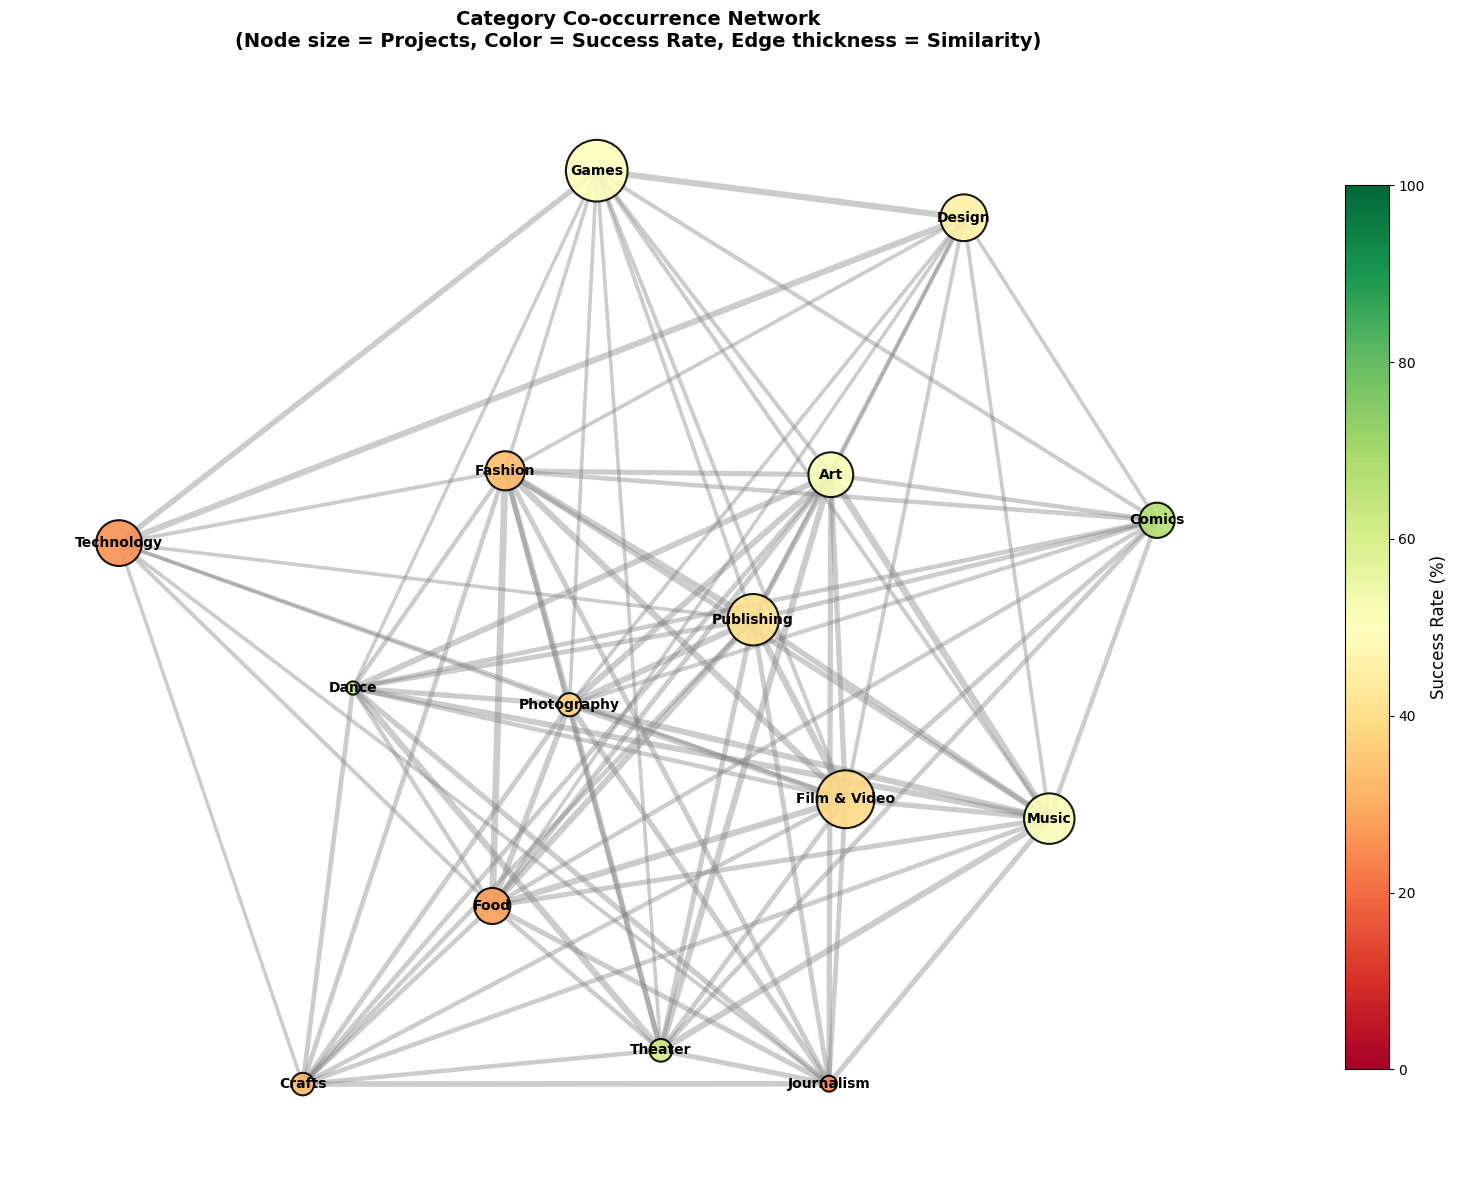

In [7]:
# Set up the plot
plt.figure(figsize=(16, 12))

# Layout - spring layout works well for showing clusters
pos = nx.spring_layout(G, k=2, iterations=50, seed=42)

# Node sizes based on total projects (scaled down for visibility)
node_sizes = [G.nodes[node]['size'] / 50 for node in G.nodes()]

# Node colors based on success rate
node_colors = [G.nodes[node]['success_rate'] for node in G.nodes()]

# Edge widths based on similarity weight
edge_widths = [G[u][v]['weight'] * 5 for u, v in G.edges()]

# Draw the network
nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap='RdYlGn',  # Red-Yellow-Green colormap
    vmin=0, vmax=100,  # Success rate range
    alpha=0.9,
    edgecolors='black',
    linewidths=1.5
)

nx.draw_networkx_edges(
    G, pos,
    width=edge_widths,
    alpha=0.4,
    edge_color='gray'
)

nx.draw_networkx_labels(
    G, pos,
    font_size=10,
    font_weight='bold'
)

# Add colorbar for success rate
sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=0, vmax=100))
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), shrink=0.8)
cbar.set_label('Success Rate (%)', fontsize=12)

plt.title('Category Co-occurrence Network\n(Node size = Projects, Color = Success Rate, Edge thickness = Similarity)', 
          fontsize=14, fontweight='bold', pad=20)
plt.axis('off')
plt.tight_layout()

# Save
plt.savefig('category_network.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [8]:
# Get top 10 countries by project volume
top_countries = df['country'].value_counts().head(10).index.tolist()

# Get top 7 categories by project volume
top_categories = category_metrics.nlargest(7, 'total_projects')['category'].tolist()

# Filter data
df_filtered = df[
    (df['country'].isin(top_countries)) & 
    (df['category_parent_name'].isin(top_categories))
]

# Calculate country-category funding
country_category = df_filtered.groupby(['country', 'category_parent_name']).agg({
    'id': 'count',  # number of projects
    'usd_pledged': 'sum',  # total funding
    'state': lambda x: (x == 'successful').sum() / len(x) * 100  # success rate
}).reset_index()

country_category.columns = ['country', 'category', 'num_projects', 'total_funding', 'success_rate']

# Only keep edges with at least 100 projects
country_category = country_category[country_category['num_projects'] >= 100]

print(f"Country-Category pairs: {len(country_category)}")
print(country_category.head(10))

Country-Category pairs: 68
  country      category  num_projects  total_funding  success_rate
0      AU           Art          1151   3.008828e+06     51.433536
1      AU        Design          1821   3.424252e+07     41.954970
2      AU  Film & Video          1503   6.228936e+06     32.069195
3      AU         Games          2854   2.874544e+07     47.582341
4      AU         Music           732   1.695602e+06     40.846995
5      AU    Publishing          1796   6.908724e+06     43.986637
6      AU    Technology          1829   3.100907e+07     18.370694
7      CA           Art          3150   1.309865e+07     56.444444
8      CA        Design          2843   5.950256e+07     43.123461
9      CA  Film & Video          2660   1.216046e+07     32.180451


In [9]:
# Create bipartite graph
B = nx.Graph()

# Add country nodes (type 0)
for country in country_category['country'].unique():
    B.add_node(country, bipartite=0, node_type='country')

# Add category nodes (type 1)
for category in country_category['category'].unique():
    B.add_node(category, bipartite=1, node_type='category')

# Add edges with funding as weight
for _, row in country_category.iterrows():
    B.add_edge(
        row['country'],
        row['category'],
        weight=row['total_funding'],
        num_projects=row['num_projects'],
        success_rate=row['success_rate']
    )

print(f"Bipartite network: {B.number_of_nodes()} nodes, {B.number_of_edges()} edges")

# Separate node sets
countries = [n for n, d in B.nodes(data=True) if d['node_type'] == 'country']
categories = [n for n, d in B.nodes(data=True) if d['node_type'] == 'category']

print(f"Countries: {len(countries)}, Categories: {len(categories)}")

Bipartite network: 17 nodes, 68 edges
Countries: 10, Categories: 7


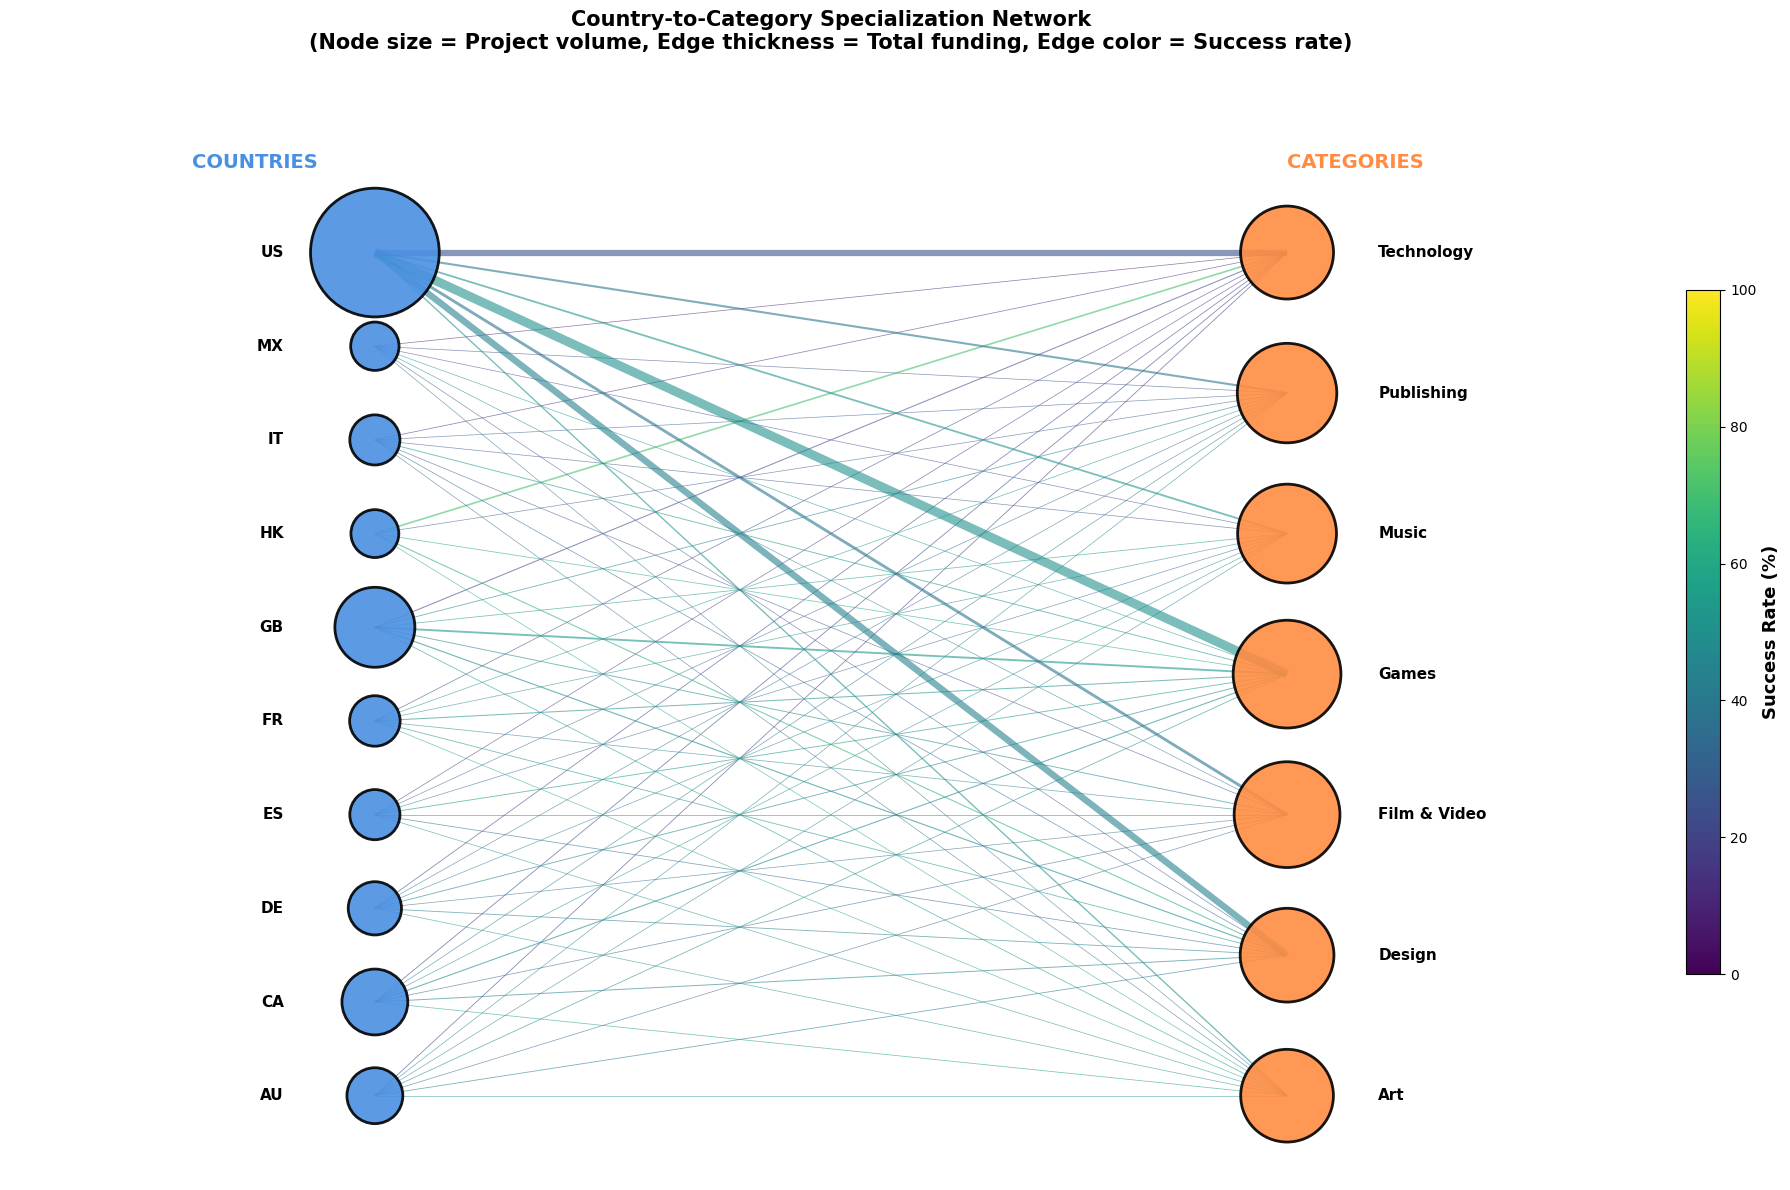

In [13]:
# Set up the plot
plt.figure(figsize=(18, 12))

# Better bipartite layout - spread nodes vertically
pos = {}

# Position countries on the left (x=0), spread vertically
country_spacing = 10 / (len(countries) - 1) if len(countries) > 1 else 0
for i, country in enumerate(sorted(countries)):
    pos[country] = (0, i * country_spacing)

# Position categories on the right (x=5), spread vertically  
category_spacing = 10 / (len(categories) - 1) if len(categories) > 1 else 0
for i, category in enumerate(sorted(categories)):
    pos[category] = (5, i * category_spacing)

# Node sizes - SCALED DOWN and capped to prevent huge nodes
country_projects = [sum([B[country][cat]['num_projects'] for cat in B.neighbors(country)]) for country in sorted(countries)]
category_projects = [sum([B[country][cat]['num_projects'] for country in B.neighbors(cat)]) for cat in sorted(categories)]

# Use log scale or square root to compress large values
import numpy as np
country_sizes = [np.sqrt(p) * 15 for p in country_projects]
category_sizes = [np.sqrt(p) * 20 for p in category_projects]

# Draw country nodes (blue, left side)
nx.draw_networkx_nodes(
    B, pos,
    nodelist=sorted(countries),
    node_size=country_sizes,
    node_color='#4A90E2',
    alpha=0.9,
    edgecolors='black',
    linewidths=2
)

# Draw category nodes (orange, right side)
nx.draw_networkx_nodes(
    B, pos,
    nodelist=sorted(categories),
    node_size=category_sizes,
    node_color='#FF8C42',
    alpha=0.9,
    edgecolors='black',
    linewidths=2
)

# Edge widths based on total funding (normalized)
max_funding = max([B[u][v]['weight'] for u, v in B.edges()])
edge_widths = [(B[u][v]['weight'] / max_funding) * 6 + 0.5 for u, v in B.edges()]

# Edge colors based on success rate - using viridis (colorblind friendly)
edge_colors = [B[u][v]['success_rate'] for u, v in B.edges()]

# Draw edges with viridis colormap (purple-blue-green-yellow)
edges = nx.draw_networkx_edges(
    B, pos,
    width=edge_widths,
    alpha=0.6,
    edge_color=edge_colors,
    edge_cmap=plt.cm.viridis,
    edge_vmin=0,
    edge_vmax=100
)

# Draw labels with offset for better readability
country_labels = {c: c for c in sorted(countries)}
category_labels = {c: c for c in sorted(categories)}

# Country labels on the left
nx.draw_networkx_labels(
    B, 
    {k: (v[0] - 0.5, v[1]) for k, v in pos.items() if k in countries},
    labels=country_labels,
    font_size=11,
    font_weight='bold',
    horizontalalignment='right'
)

# Category labels on the right
nx.draw_networkx_labels(
    B,
    {k: (v[0] + 0.5, v[1]) for k, v in pos.items() if k in categories},
    labels=category_labels,
    font_size=11,
    font_weight='bold',
    horizontalalignment='left'
)

# Add colorbar with viridis
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=100))
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), fraction=0.02, pad=0.02)
cbar.set_label('Success Rate (%)', fontsize=13, weight='bold')

# Add text annotations
plt.text(-1, 11, 'COUNTRIES', fontsize=14, weight='bold', color='#4A90E2')
plt.text(5, 11, 'CATEGORIES', fontsize=14, weight='bold', color='#FF8C42')

plt.title('Country-to-Category Specialization Network\n(Node size = Project volume, Edge thickness = Total funding, Edge color = Success rate)', 
          fontsize=15, fontweight='bold', pad=25)
plt.xlim(-2, 7)
plt.ylim(-1, 12)
plt.axis('off')
plt.tight_layout()

# Save
plt.savefig('country_category_bipartite_clean.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [14]:
# Get creators who launched in multiple categories
creator_categories = df.groupby('creator_id')['category_parent_name'].apply(list).reset_index()

# Filter to creators with 2+ categories
multi_category_creators = creator_categories[creator_categories['category_parent_name'].apply(len) >= 2]

print(f"Found {len(multi_category_creators)} creators who launched in multiple categories")
print(multi_category_creators.head())

Found 74367 creators who launched in multiple categories
   creator_id               category_parent_name
0           3                      [Art, Design]
1           4            [Film & Video, Fashion]
2           8     [Publishing, Fashion, Fashion]
3           9    [Technology, Music, Technology]
4          11  [Art, Music, Music, Music, Music]


In [15]:
from itertools import combinations

# Build edges between categories that creators tried together
edge_counts = {}

for _, row in multi_category_creators.iterrows():
    categories = list(set(row['category_parent_name']))  # Remove duplicates
    
    # Create all pairs of categories this creator tried
    if len(categories) >= 2:
        for cat1, cat2 in combinations(sorted(categories), 2):
            pair = tuple(sorted([cat1, cat2]))
            edge_counts[pair] = edge_counts.get(pair, 0) + 1

# Convert to dataframe
creator_edges = pd.DataFrame([
    {'source': pair[0], 'target': pair[1], 'weight': count}
    for pair, count in edge_counts.items()
])

# Sort by weight
creator_edges = creator_edges.sort_values('weight', ascending=False)

print(f"Created {len(creator_edges)} category pairs")
print("\nTop 10 category transitions:")
print(creator_edges.head(10))

Created 105 category pairs

Top 10 category transitions:
          source      target  weight
5            Art     Fashion    1612
9         Design  Technology    1455
26           Art  Publishing    1386
27         Games  Publishing    1288
13        Design     Fashion    1283
16           Art       Games    1173
0            Art      Design    1166
12        Comics  Publishing     936
17  Film & Video  Publishing     936
18        Design       Games     820


In [16]:
# Create network
G_creators = nx.Graph()

# Add all category nodes
for category in category_metrics['category'].unique():
    G_creators.add_node(category)

# Add edges (only keep edges with at least 100 creators for clarity)
min_creators = 100
for _, edge in creator_edges[creator_edges['weight'] >= min_creators].iterrows():
    G_creators.add_edge(
        edge['source'],
        edge['target'],
        weight=edge['weight']
    )

print(f"Creator network: {G_creators.number_of_nodes()} nodes, {G_creators.number_of_edges()} edges")

Creator network: 15 nodes, 58 edges


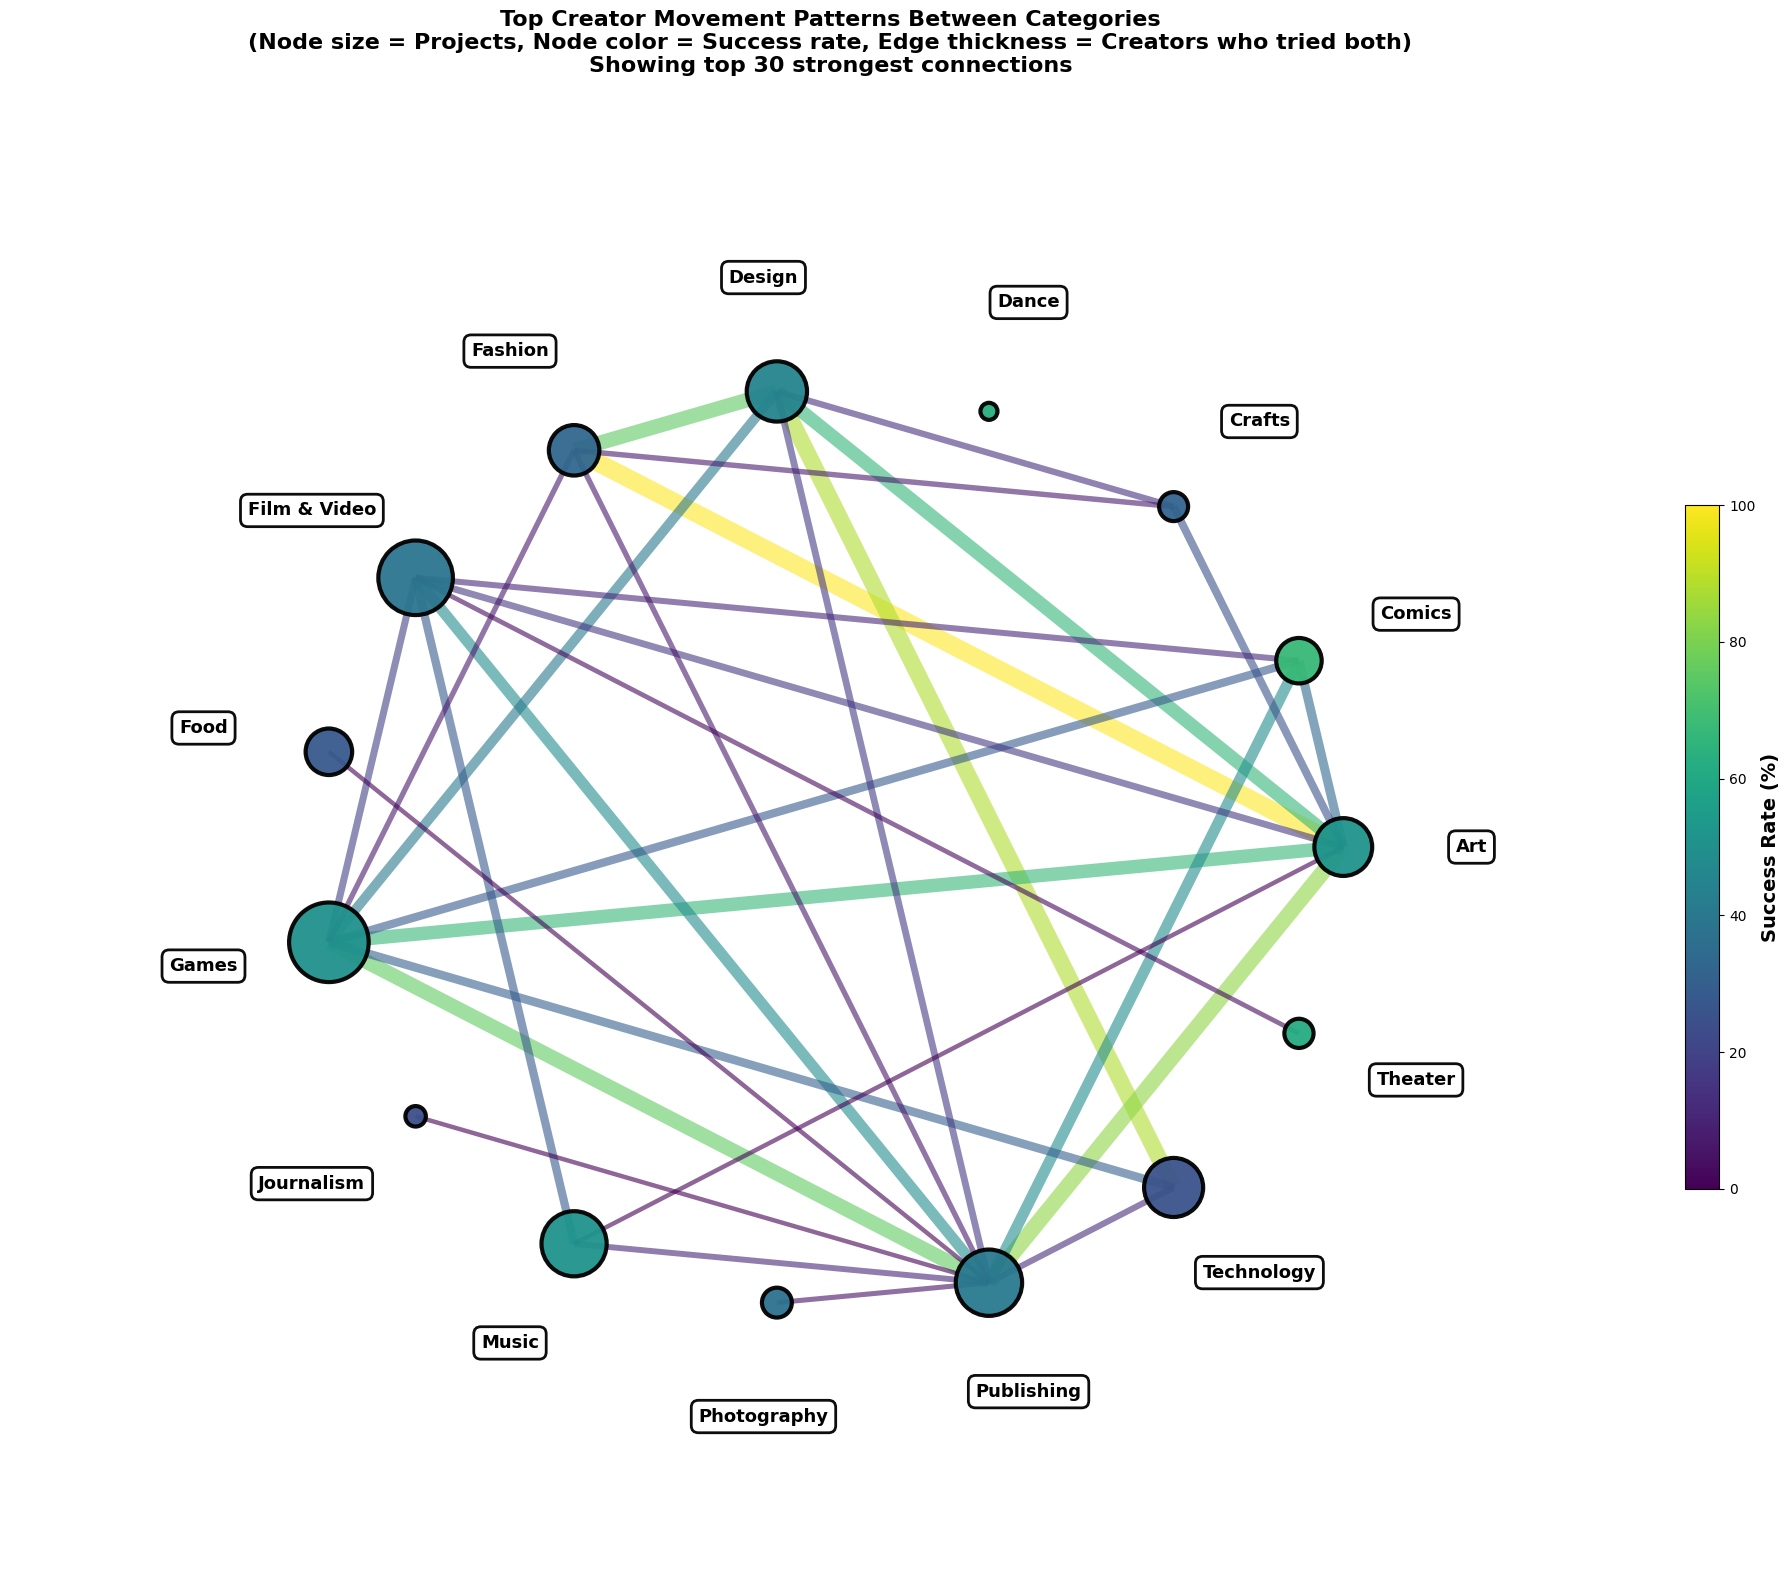

In [21]:
# Set up the plot
plt.figure(figsize=(18, 16))

# Use circular layout - cleaner for highly connected networks
pos = nx.circular_layout(G_creators)

# Node sizes based on total projects
node_sizes = []
for node in G_creators.nodes():
    total = category_metrics[category_metrics['category'] == node]['total_projects'].values[0]
    node_sizes.append(total / 30)

# Node colors based on success rate
node_colors = []
for node in G_creators.nodes():
    success = category_metrics[category_metrics['category'] == node]['success_rate'].values[0]
    node_colors.append(success)

# Edge widths - only show strong connections (top 30)
top_edges = creator_edges.nlargest(30, 'weight')
edges_to_draw = [(row['source'], row['target']) for _, row in top_edges.iterrows()]
edge_widths_dict = {(row['source'], row['target']): row['weight'] for _, row in top_edges.iterrows()}

# Normalize edge widths
max_weight = top_edges['weight'].max()
edge_widths = [(edge_widths_dict.get((u,v), edge_widths_dict.get((v,u), 0)) / max_weight) * 12 + 1 
               for u, v in edges_to_draw]

edge_colors = [edge_widths_dict.get((u,v), edge_widths_dict.get((v,u), 0)) for u, v in edges_to_draw]

# Draw nodes
nx.draw_networkx_nodes(
    G_creators, pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.viridis,
    vmin=0, vmax=100,
    alpha=0.95,
    edgecolors='black',
    linewidths=3
)

# Draw only top edges
nx.draw_networkx_edges(
    G_creators, pos,
    edgelist=edges_to_draw,
    width=edge_widths,
    alpha=0.6,
    edge_color=edge_colors,
    edge_cmap=plt.cm.viridis,
    edge_vmin=min(edge_colors),
    edge_vmax=max(edge_colors)
)

# Draw labels outside the circle
label_pos = {}
for node, (x, y) in pos.items():
    # Push labels outward
    angle = np.arctan2(y, x)
    label_pos[node] = (x * 1.25, y * 1.25)

for node, (x, y) in label_pos.items():
    plt.text(x, y, node,
             fontsize=13,
             fontweight='bold',
             ha='center',
             va='center',
             bbox=dict(boxstyle='round,pad=0.4', facecolor='white', edgecolor='black', linewidth=2, alpha=0.95))

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=100))
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), fraction=0.02, pad=0.02)
cbar.set_label('Success Rate (%)', fontsize=14, weight='bold')

plt.title('Top Creator Movement Patterns Between Categories\n(Node size = Projects, Node color = Success rate, Edge thickness = Creators who tried both)\nShowing top 30 strongest connections', 
          fontsize=16, fontweight='bold', pad=30)
plt.axis('off')
plt.xlim(-1.6, 1.6)
plt.ylim(-1.6, 1.6)
plt.tight_layout()

# Save
plt.savefig('creator_movement_network.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()